<h1> COVID-19 Classifier  </h1>

<h2> Important Steps in Implementing a Machine Learning / Deep Learning Model</h2>

<ol>
    <li> Understanding the Problem Statement </li>
    <li> Data Collection </li>
    <li> Exploratory Data Analysis (EDA) </li>
    <li> Data Preprocessing </li>
    <li> Model Building </li>
    <li> Hyper Parameter Tuning</li>
    <li> Model Evalution </li>
    
</ol>
    

<h2> 1. Problem Statement </h2>

<font size='3'> Train an automated machine learning model to assist in the diagnosis of COVID-19 infection in chest x-ray images <font>

<h2> 2. Data Collection </h2>

<font size='3'>The Chest X-ray dataset used to train the model in this notebook is taken from Kaggle. It can be found in the below link</font> <br>

<a href='https://www.kaggle.com/datasets/unaissait/curated-chest-xray-image-dataset-for-covid19'> https://www.kaggle.com/datasets/unaissait/curated-chest-xray-image-dataset-for-covid19</a>

<font size='2'> The dataset is organized into 2 folders for each image category (Covid-19/Normal). There are totally 4626 Chest X-Ray Images in which 2313 Normal and 2313 Covid-19 Chest X-ray Images <font>

## Import the required Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import pickle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import warnings
warnings.filterwarnings("ignore")

## Reading the Data

In [2]:
my_data_dir = "C:\\Users\\hp\\Downloads\\Chest_X-ray"

In [3]:
categories = os.listdir(my_data_dir)

In [4]:
categories

['anormal', 'covid']

In [5]:
X = []
y = []

for i in categories:
    path = os.path.join(my_data_dir,i)
    
    for j in os.listdir(path):
        im = cv2.imread(os.path.join(path,j))
        nim = cv2.resize(im,(128,128))
        X.append(nim)
        y.append(categories.index(i))

## 3. Exploratory Data Analysis (EDS)

In [37]:
print("The number of training samples in the dataset: ",len(X_train))

The number of training samples in the dataset:  3238


In [38]:
print("The number of testing samples in the dataset: ",len(X_test))

The number of testing samples in the dataset:  1388


In [39]:
print("The shape of the images in the dataset: ",X_train[0].shape)

The shape of the images in the dataset:  (128, 128, 3)


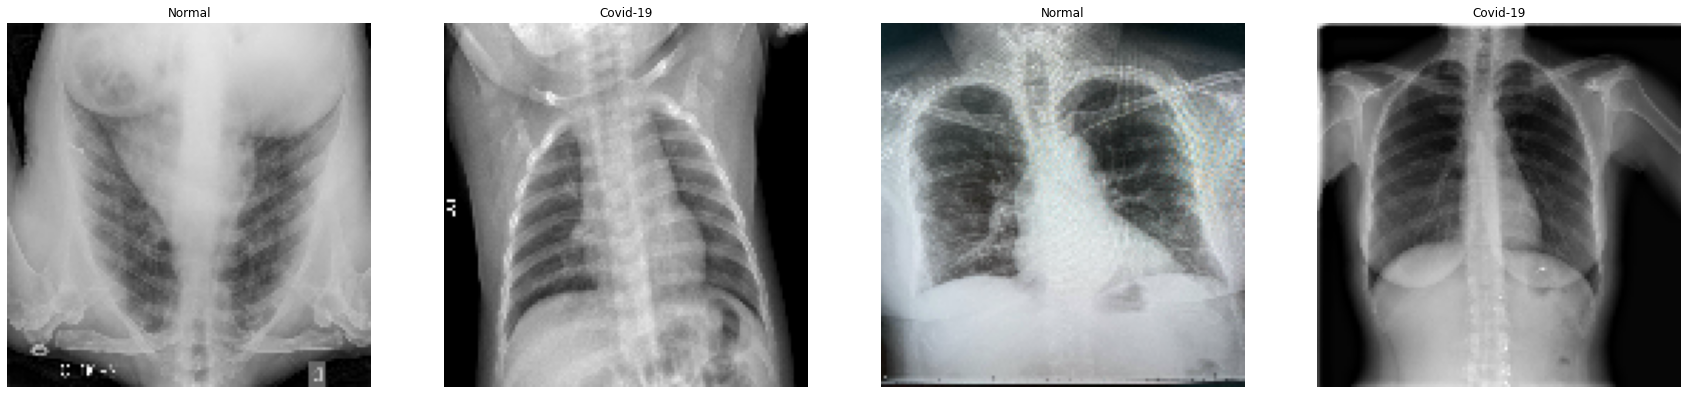

In [40]:
fig, axes = plt.subplots(1, 4,figsize=(30,10))
for i in range(0,4):
    axes[i].imshow(X_train[i])
    axes[i].axis('off')
    if(y_train[i] == 0):
        axes[i].set_title("Normal")
    else:
        axes[i].set_title("Covid-19")

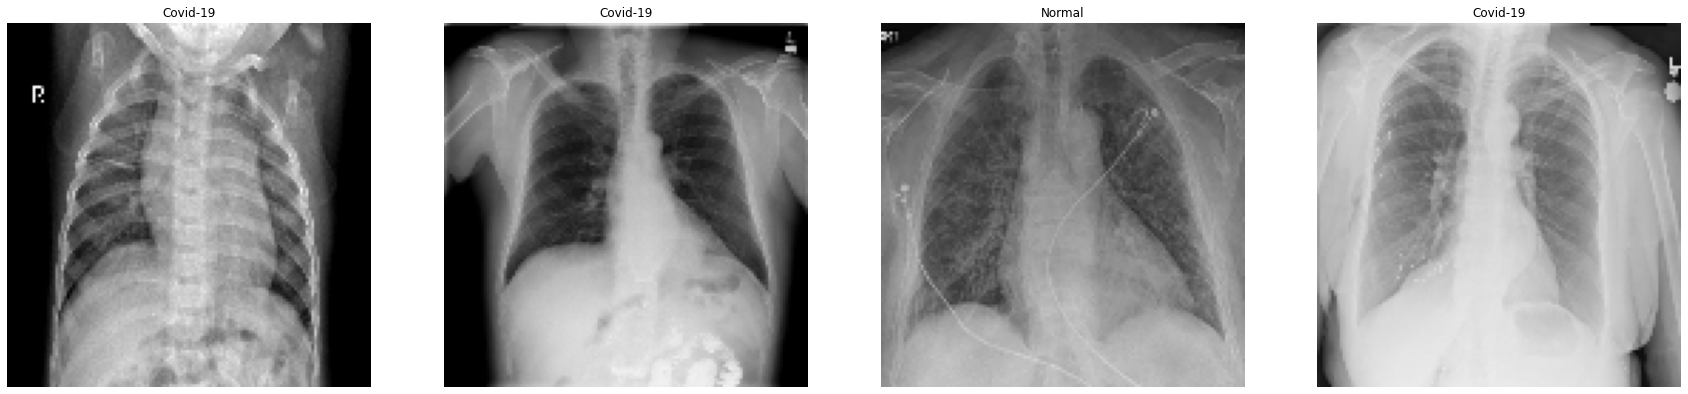

In [41]:
fig, axes = plt.subplots(1, 4,figsize=(30,10))
j = 0
for i in range(999,1003):
    axes[j].imshow(X_train[i])
    axes[j].axis('off')
    if(y_train[i] == 0):
        axes[j].set_title("Normal")
    else:
        axes[j].set_title("Covid-19")
    j = j + 1

## 4. Data Pre-processing

<b> Now we are normalizing the image array by dividing it with 255. This helps to keep the numbers small and the computation becomes easier and faster. As the pixel values range from 0 to 256, apart from 0 the range is 255. So dividing all the values by 255 will convert it to range from 0 to 1 <b>

In [23]:
X_train = np.array(X_train)

In [24]:
X_test = np.array(X_test)

In [25]:
X_train = X_train/255.0

In [26]:
X_test = X_test/255.0

In [27]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [28]:
y_train_svm = np.array(y_train)
y_test_svm = np.array(y_test)

### Train Test Split

<b> Here we are splitting our data and labels into training and testing using a function named 'Train test split' in sklearn library. The data is splitted into 70% Training and 30% Testing with random state of 0.<b>

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=0)

<b> Before applying the Principle Component Analysis(PCA), the image data should be reshaped into 2D image <b>

In [32]:
X_train_svm = np.reshape(X_train, (len(X_train), -1))

In [33]:
X_test_svm = np.reshape(X_test, (len(X_test), -1))

### Principle Component Analysis (PCA) 

<b> PCA helps us to extract the most important features from the image dataset and reduce the dimensionality of our data which helps in removing noise and redundancy from the image dataset. Here we keeping the principal components that preserve 95% of the variance in the data.<b>

In [39]:
# Initialize the PCA model
pca = PCA(n_components=0.95)

# Fit the PCA model to the training data
pca.fit(X_train_svm)

# Apply the PCA transformation to the training and test data
X_train_pca = pca.transform(X_train_svm)
X_test_pca = pca.transform(X_test_svm)

<font size='4'> <b> Soft-Margin SVM implementation from scratch<b> <font>

In [29]:
class SVM:

    def __init__(self, learning_rate=0.01, lambda_param=0.01, n_iters=300, C=1):
        
        self.lr = learning_rate   # learning rate for the update rule
        self.lambda_param = lambda_param    # regularization parameter
        self.n_iters = n_iters   # number of iterations for the loop
        self.C = C  # parameter to control the trade-off between maximizing the margin and allowing for misclassifications
        self.w = None  # weight vector, initialized to None
        self.b = None  # bias term, initialized to None
        

    def fit(self, X, y):
        n_samples, n_features = X.shape  

        y_ = np.where(y <= 0, -1, 1)  # convert labels to -1 and 1

        # init weights and bias to zero
        self.w = np.zeros(n_features)
        self.b = 0
        
        # iterating through the samples for assigned n_iter times
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                # check if sample is not classified update the weight the bias
                if y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1: 
                    self.w -= self.lr * (2 * self.lambda_param * self.w)   #update weight vector
                    
                # if the sample is misclassified update the weight
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - self.C * np.dot(x_i, y_[idx]))  # update weight vector
                    self.b -= self.lr * y_[idx]   # update bias term
                    
    
    # function to predic the label of the class
    def predict(self, X):
        approx = np.dot(X, self.w) - self.b  # calculate the approximate value
        predicted_labels = np.sign(approx)
        y_hat = np.where(predicted_labels <= -1, 0, 1)
        return y_hat  


<font size='4' > <b> 5. Training the Model <b> <font>

In [30]:
svm_model = SVM()

In [40]:
svm_model.fit(X_train_pca,y_train_svm)

<font size='4'> <b> 6. Evaluating the Model <b> <font>

In [41]:
y_pred_svm = svm_model.predict(X_test_pca)

In [42]:
print("The testing accuracy of the model: ",accuracy_score(y_pred_svm,y_test)*100)

The testing accuracy of the model:  85.99827139152983


In [43]:
y_pred_train_svm = svm_model.predict(X_train_pca)

In [25]:
print("The training accuracy of the model: ",accuracy_score(y_pred_train_svm,y_train_svm)*100)

The training accuracy of the model:  87.12168004941321


In [45]:
print(classification_report(y_pred_svm,y_test_svm))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       566
           1       0.87      0.85      0.86       591

    accuracy                           0.86      1157
   macro avg       0.86      0.86      0.86      1157
weighted avg       0.86      0.86      0.86      1157



In [46]:
confusion_matrix(y_pred_svm,y_test_svm)

array([[492,  74],
       [ 88, 503]], dtype=int64)

## Convolution Neural Network (CNN)

### Data Agumentation
Image data generation is a in-built function in keras libray which helps manipulate the images by rotation, resizing, and scaling, so the model becomes more robust to different images that doesn't have in our data set.

In [47]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [48]:
datagen.fit(X_train)

<b> Generation of manipulated images from the exsisting training data<b>

In [49]:
train_cnn = datagen.flow(X_train,y_train, batch_size=16)

In [50]:
# shape of our image
image_shape = (128,128,3)

<font size='4' > <b>Creating the Model<b> <font>

In [51]:
model_cnn = Sequential()

model_cnn.add(Conv2D(filters=128, kernel_size=(3,3),input_shape=image_shape, activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))


model_cnn.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))


model_cnn.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))


model_cnn.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))




model_cnn.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))


model_cnn.add(Flatten())


model_cnn.add(Dense(128))
model_cnn.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model_cnn.add(Dropout(0.5))

# Last layer, remember its binary so we use sigmoid
model_cnn.add(Dense(2))
model_cnn.add(Activation('sigmoid'))

<font size='4' > <b> Compile the Model <b> <font>

In [52]:
model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

<font size='3' > <b> Summary of the Model <b> <font>

In [53]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

<font size='4' > <b> Early Stopping <b> <font>

In [54]:
early_stop = EarlyStopping(monitor='loss',patience=2)

<font size='4' > <b> Training the Model <b> <font>

In [55]:
batch_size = 16
epochs = 20

In [56]:
history = model_cnn.fit_generator(train_cnn, epochs = epochs,steps_per_epoch=X_train.shape[0] // batch_size,callbacks=['early_stop'])

Epoch 1/20
216/216 [==============================] - 133s 603ms/step - loss: 0.6852 - accuracy: 0.5578
Epoch 2/20
216/216 [==============================] - 129s 596ms/step - loss: 0.5928 - accuracy: 0.6817
Epoch 3/20
216/216 [==============================] - 128s 592ms/step - loss: 0.5021 - accuracy: 0.7648
Epoch 4/20
216/216 [==============================] - 131s 607ms/step - loss: 0.4434 - accuracy: 0.7955
Epoch 5/20
216/216 [==============================] - 175s 809ms/step - loss: 0.3737 - accuracy: 0.8372
Epoch 6/20
216/216 [==============================] - 140s 645ms/step - loss: 0.3318 - accuracy: 0.8636
Epoch 7/20
216/216 [==============================] - 124s 573ms/step - loss: 0.2795 - accuracy: 0.8885
Epoch 8/20
216/216 [==============================] - 129s 597ms/step - loss: 0.2779 - accuracy: 0.8914
Epoch 9/20
216/216 [==============================] - 149s 688ms/step - loss: 0.2455 - accuracy: 0.9021
Epoch 10/20
216/216 [==============================] - 126s 581m

<font size='3' > <b> Saving the Model <b> <font>

In [57]:
model_cnn.save('Covid_Classifier.h5')

<font size='4'> <b> Evaluating the Model <b> <font>

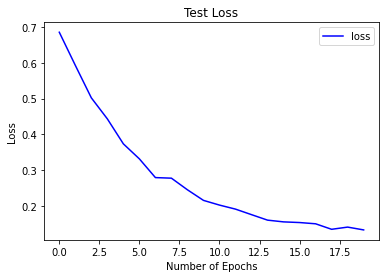

In [58]:
# Plot the loss and accuracy curves for training and validation 
plt.plot(history.history['loss'], color='b', label="loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [72]:
y_pred = np.argmax(model_cnn.predict(X_test), axis=-1)

37/37 [==============================] - 9s 250ms/step


In [73]:
print("The accuracy of the CNN model is:",accuracy_score(y_pred,y_test)*100)

The accuracy of the CNN model is: 96.88850475367329
